<a href="https://colab.research.google.com/github/RoyElkabetz/NMR-gyroscope/blob/main/Quantization_noise_simulation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import scipy.signal as sps
import scipy as sp
import matplotlib.pyplot as plt

## Useful Functions

In [37]:
def smooth(y, box_pts=10):
    """Smoothing a signal using mooving average"""
    box = np.ones(box_pts) / box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth


def butter_low_pass_filter(x, order, cutoff_hz, sampling_frequency_hz, plot_filter=False):
    """Returns the filtered signal using a Butterworth low pass filter"""
    b, a = sp.signal.butter(order, cutoff_hz / (sampling_frequency_hz / 2), btype='low', analog=False)
    filtered_x = sp.signal.filtfilt(b, a, x)
    if plot_filter:
        # plot the filter frequency response
        w, h = sps.freqz(b, a, fs=sampling_frequency_hz)
        plt.semilogx(w, 20 * np.log10(abs(h)))
        plt.title('Butterworth filter frequency response')
        plt.xlabel('Frequency [rad / sec]')
        plt.ylabel('Amplitude [dB]')
        plt.grid(which='both', axis='both')
        plt.axvline(cutoff_hz, color='green') # cutoff frequency
        plt.show()
    return filtered_x


def psd_compare(signals_list, sampling_frequency_hz, noise_amplitude=None, names=None):
    """ Plot the Power Spectral Density (PSD) of all signals in the signals list 
        in units of \sqrt(power) / \sqrt(Hz) 
    """
    frequencies = []
    psd = []
    for x in signals_list:
        f, Pxx = sps.welch(x, fs=sampling_frequency_hz)
        frequencies.append(f)
        psd.append(np.sqrt(Pxx))
    

    fig = plt.figure(figsize=(20, 4))
    ax = plt.subplot(111)
    ax.set_title('The Power Spectral Density (PSD) plot')
    for i in range(len(psd)):
        if names is not None and len(names) == len(psd):
            ax.loglog(frequencies[i], psd[i], label=names[i])
        else:
            ax.loglog(frequencies[i], psd[i], label=str(i))
    if noise_amplitude is not None:
        ax.hlines(noise_amplitude, frequencies[i].min(), frequencies[i].max(), label='noise amplitude')
    ax.set_ylabel(r'PSD $\left[\sqrt{\frac{a.u.}{Hz}}\right]$')
    ax.set_xlabel('Frequency [Hz]')
    ax.legend()
    ax.grid(True)

## Generating White Gaussian Noise

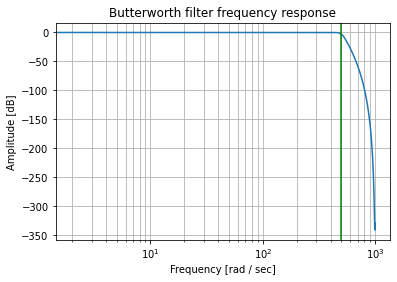

In [33]:
# Noise parameters
frequency = 2                           # sine wave frequency [Hz]
sampling_frequency = 1000 * frequency     # sampling frequency [Hz]
t_f = 1                                # final time of time vector [s]
dt = 1 / sampling_frequency             # time step for simulation [s]
N = np.int(t_f // dt)                   # sampling points in time vector
t = np.linspace(0, t_f, N)              # time vector  [s]
noise_amplitude = 0.067                # noise amplitude [amplitude / sqrt(Hz)]
noise_power = np.power(noise_amplitude, 2) * sampling_frequency / 2 # noise power [power / Hz]


# Filter parameters
cutoff = sampling_frequency / 4                             # noise cutoff frequency [Hz]
order = 10                             # order of the low pass filter

# The noise
noise = np.random.normal(scale=np.sqrt(noise_power), size=t.shape)

# Filtered noise
filtered_noise = butter_low_pass_filter(noise, 
                                        order, 
                                        cutoff, 
                                        sampling_frequency, 
                                        plot_filter=True) # filtered noise

## Quantizing White Noise into a single bit - Smooth and Quant

In [34]:
quant_level = 0
quantized_wn_1bit = np.zeros_like(noise) - np.sqrt(noise_power)
quantized_wn_1bit[smooth(noise) > quant_level] = np.sqrt(noise_power)

quantized_filtered_wn_1bit = np.zeros_like(filtered_noise) - np.sqrt(noise_power)
quantized_filtered_wn_1bit[smooth(filtered_noise) > quant_level] = np.sqrt(noise_power)

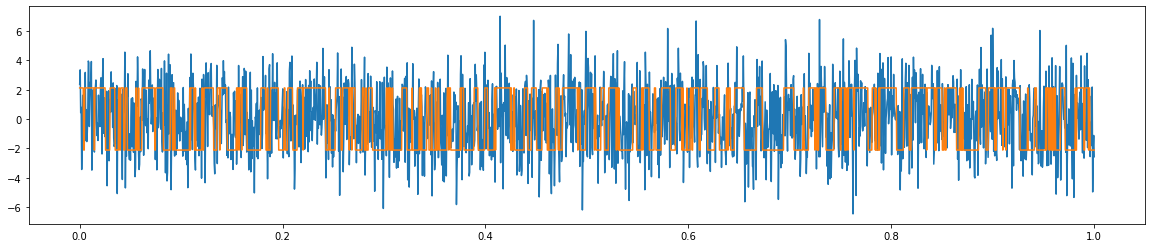

In [35]:
plt.figure(figsize=(20, 4))
plt.plot(t, noise)
plt.plot(t, quantized_wn_1bit)
plt.show()

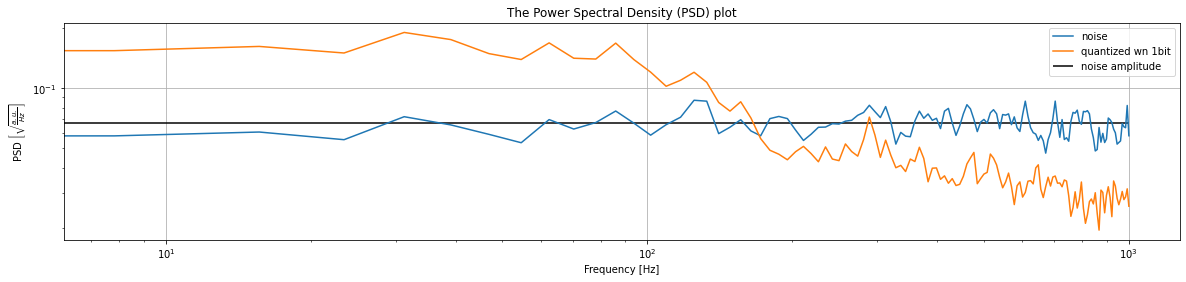

In [39]:
# noise_list = [noise, filtered_noise, quantized_wn_1bit, quantized_filtered_wn_1bit]
# names = ['noise', 'filtered_noise', 'quantized wn 1bit', 'quantized filtered wn 1bit',]

noise_list = [noise, quantized_wn_1bit]
names = ['noise', 'quantized wn 1bit']


# plot PSD of all signals
psd_compare(noise_list, sampling_frequency, noise_amplitude=noise_amplitude, names=names)


## Quantizing White Noise into a single bit - quant and smooth

In [40]:
quant_level = 0
quantized_wn_1bit = np.zeros_like(noise) - np.sqrt(noise_power)
quantized_wn_1bit[noise > quant_level] = np.sqrt(noise_power)

quantized_filtered_wn_1bit = np.zeros_like(filtered_noise) - np.sqrt(noise_power)
quantized_filtered_wn_1bit[filtered_noise > quant_level] = np.sqrt(noise_power)

quantized_wn_1bit = smooth(quantized_wn_1bit)
quantized_filtered_wn_1bit = smooth(quantized_filtered_wn_1bit)

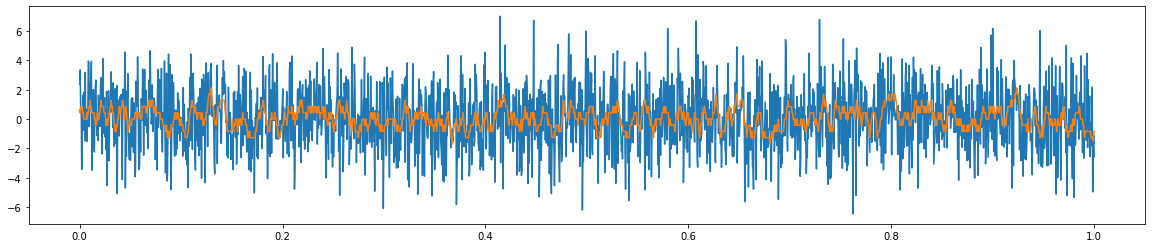

In [41]:
plt.figure(figsize=(20, 4))
plt.plot(t, noise)
plt.plot(t, quantized_wn_1bit)
plt.show()

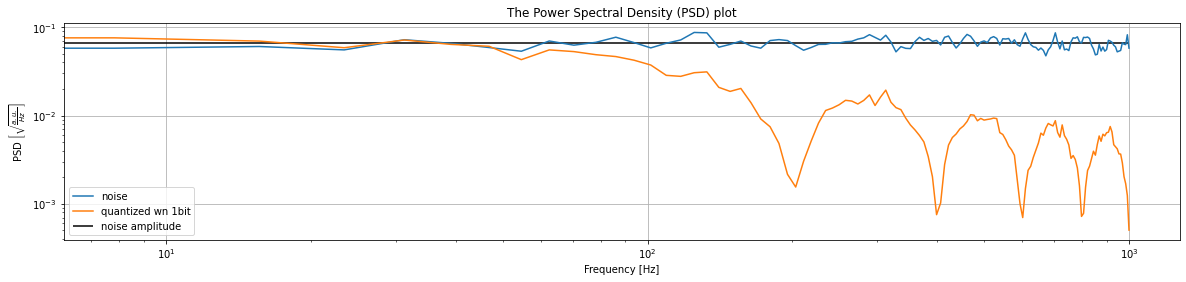

In [42]:
noise_list = [noise, quantized_wn_1bit]
names = ['noise', 'quantized wn 1bit']


# plot PSD of all signals
psd_compare(noise_list, sampling_frequency, noise_amplitude=noise_amplitude, names=names)
